In [3]:
@attr.s
class DqnBaseClass:
    env = attr.ib()
    discount_rate = attr.ib(default=0.99)
    epsilon_max = attr.ib(default=1.0)
    epsilon_min = attr.ib(default=0.01)
    annealing_const = attr.ib(default=.001)  # aka Lambda
    minibatch_size = attr.ib(default=64)
    memory_size = attr.ib(default=int(1e6))
    num_episodes = attr.ib(default=1000)  # num of episodes in a training epoch
    num_hidden_units = attr.ib(default=64)
    render_every = attr.ib(default=20)  # set to zero to turn off rendering
    update_target_every = attr.ib(default=200)
    reward_clip_ceiling = attr.ib(None)
    reward_clip_floor = attr.ib(None)

    def __attrs_post_init__(self):
        self.steps = 0
        self.reset_memory()
        self.reset_data_recorders()
        self.state_shape = self.env.observation_space.shape
        self.action_shape = self.env.action_space.n
        self.online_net = make_network(self.state_shape, self.action_shape, self.num_hidden_units)

    def reset_memory(self):
        self.memory = Memory(self.memory_size, self.minibatch_size)

    def reset_data_recorders(self):
        self.episode_rewards = []
        self.episode_losses = []
        self.td_errors = []
        self.online_net_q_values = []
        self.target_net_q_values = []
        self.w1_gradient = []
        self.w2_gradient = []

    def q_value_one(self, net, state):
        return net.predict(state.reshape((1, self.state_shape[0]))).flatten()

    def training_rewards_string(self, episode):
        last_ep = self.episode_rewards[-1]
        ten_ep_mean = sum(self.episode_rewards[-10:])/len(self.episode_rewards[-10:])
        hundred_ep_mean = sum(self.episode_rewards[-100:])/len(self.episode_rewards[-100:])
        return f'Ep: {episode} // steps: {self.steps} // last ep reward: {last_ep:.2f} // {min(10, len(self.episode_rewards[-10:]))}-ep mean: {ten_ep_mean:.2f} // {min(100, len(self.episode_rewards[-100:]))}-ep mean: {hundred_ep_mean:.2f}'

    def render(self, episode):
        if self.render_every and episode % self.render_every == 0:
            self.env.render()

    # TODO: rename to train
    def run(self):
        raise NotImplementedError
        
    def display(self, num_episodes=1):
        state = self.env.reset()
        episode_done = False
        episode_td_errors = 0
        self.reset_data_recorders()
        for episode in range(num_episodes)
            while not episode_done:            
                action = self.q_value_one(self.online_net, state).argmax()                    
                self.env.render()
                state_, reward, episode_done, _ = self.env.step(action)
                episode_reward += reward
                episode_td_errors = self.replay(target_net=self.online_net, online_net=self.online_net)
                self.td_errors.append(episode_td_errors)
                state = state_
                if episode_done:
                    self.episode_rewards.append(episode_reward)                    
                    print(self.training_rewards_string(episode), end='\r', flush=True)
        self.env.close()        
        return episode_td_errors

### Prioritized Experience Replay

Prioritized Experience Replay tries to use experience more efficiently by assigning higher probabilities to transitions which may have more to teach us. "More to teach us" is, obviously, a difficult concept to quantify, but one potentially good proxy for it is the temporal difference error of a transition. A larger error indicates a greater surprise factor. 

In the [Rainbow DQN](https://arxiv.org/abs/1710.02298) paper, the authors found that PER was one of the most impactful improvements to the DQN framework, and there are some obvious additional prioritization schemes, for example providing a higher priority to rollouts where the total score was higher. However, at this point I have simply implemented PER as outline in the [original paper](https://arxiv.org/abs/1511.05952). 

Storing and retrieving transitions with priorities requires us to use a different data structure for our memory. The PER paper outlines two different ways to calculate transition priorities, each with their own custom data structure. For this implementation I am using Jaromiru's [SumTree](https://github.com/jaara/AI-blog/blob/master/SumTree.py) reference implementation. Please see their excellent [blog post](https://jaromiru.com/2016/11/07/lets-make-a-dqn-double-learning-and-prioritized-experience-replay/) for further details.

In [207]:
from SumTree import SumTree


@attr.s
class PriorityMemory:
    size = attr.ib()
    batch_size = attr.ib()
    epsilon = attr.ib(default=0.01)
    alpha = attr.ib(default=0.6)

    def __attrs_post_init__(self):
        self.sumtree = SumTree(capacity=self.size)
        self._len = 0

    def __len__(self):
        return self._len

    def _td_error_to_priority(self, td_error):
        return (td_error + self.epsilon) ** self.alpha

    def store(self, td_error, transition):
        self._len += 1
        priority = self._td_error_to_priority(td_error)
        self.sumtree.add(priority, transition)

    def sample(self):
        # https://github.com/jaara/AI-blog/blob/master/Seaquest-DDQN-PER.py#L102
        batch = []
        segment_size = self.sumtree.total() // self.batch_size
        for index in range(self.batch_size):
            a = segment_size * index
            b = segment_size * (index + 1)
            s = random.uniform(a, b)
            batch.append(self.sumtree.get(s))  # a list of (idx, p, data) tuples
        return batch

    def update(self, idx, td_error):
        priority = self._td_error_to_priority(td_error)
        self.sumtree.update(idx, priority)

In [306]:
@attr.s
class PrioritizedDqn(DqnBaseClass):
    random_init_steps = attr.ib(1000)
    
    def __attrs_post_init__(self):
        super().__attrs_post_init__()
        self.target_net = make_network(self.state_shape, self.action_shape, self.num_hidden_units)
        self.memory = PriorityMemory(self.memory_size, self.minibatch_size)
        print('Starting to initializing memory with random agent.')
        state = self.env.reset()
        for _ in range(self.random_init_steps):
            action = random.randint(0, self.action_shape-1)
            state_, reward, episode_done, _ = self.env.step(action)
            # See https://jaromiru.com/2016/11/07/lets-make-a-dqn-double-learning-and-prioritized-experience-replay/
            # for discussion of random init and rewards as naive error signal
            self.memory.store(reward, (state, action, abs(reward), state_, episode_done))
            if episode_done:
                state = self.env.reset()
            else:
                state = state_
        print('Finished initializing memory with random agent.')
        
    def replay(self):
        batch = self.memory.sample()  # A list of (idx, prob, observation) tuples
        observations = [observe[2] for observe in batch]
        states = np.array([transition[0] for transition in observations])  # (observations x state-size)
        transition_actions = np.array([transition[1] for transition in observations])
        rewards = np.array([transition[2] for transition in observations])  # (observations x 1)
        terminal_mask = np.array([True if transition[3] is None else False for transition in observations])  # (observations x 1)
        terminal_state = np.zeros(self.state_shape)
        states_ = np.array([transition[3] if transition[3] is not None else terminal_state for transition in observations])  # (observations x state-size)

        # set y = r for terminal states:
        terminal_state_actions = transition_actions[terminal_mask]
        y = self.target_net.predict(states)  # (observations x num-actions)
        y[terminal_mask, terminal_state_actions] = rewards[terminal_mask]

        # DDQN update:
        # set y = r + gamma * Q_hat(s', argmax Q(s', a')). Remember that y_ is the output of Q_hat, aka target_net.
        non_terminal_mask = ~terminal_mask
        online_predicted_actions_ = self.online_net.predict(states_).argmax(axis=1)  # observations x num-action
        best_actions = online_predicted_actions_[non_terminal_mask]
        non_terminal_actions = transition_actions[non_terminal_mask]
        y_ = self.target_net.predict(states_)  # (observations x num-actions)
        y[non_terminal_mask, non_terminal_actions] = rewards[non_terminal_mask] + self.discount_rate * y_[non_terminal_mask, best_actions]

        priorities = np.array([observe[1] for observe in batch])
        probabilities = priorities / sum(priorities)
        BETA = 0.4
        weights = (self.memory_size * probabilities) ** -BETA
        weights = weights / weights.max()
        self.online_net.fit(states, y, batch_size=64, epochs=1, sample_weight=weights, verbose=0)  # REMEBER, Q is a func from (state, action) pairs to values.

        memory_indices = [observe[0] for observe in batch]
        target_predictions = self.target_net.predict(states_)[range(self.minibatch_size), online_predicted_actions_]
        online_predictions = self.online_net.predict(states)[range(self.minibatch_size), transition_actions]

        td_errors = rewards + self.discount_rate * target_predictions - online_predictions  # should be (batch x 1)        
        td_errors = np.abs(td_errors)
        for idx, error in zip(memory_indices, td_errors):
            self.memory.update(idx, error)
        return np.linalg.norm(td_errors)/self.minibatch_size

    def run(self):        
        for episode in range(self.num_episodes):
            episode_done = False
            episode_reward = 0
            episode_td_errors = 0
            state = self.env.reset()
            self.online_net_q_values.append(self.q_value_one(self.online_net, state).max())
            self.target_net_q_values.append(self.q_value_one(self.target_net, state).max())
            while not episode_done:
                epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * math.exp(-self.annealing_const * self.steps)
                self.steps += 1
                if random.random() < epsilon:
                    action = random.randint(0, self.action_shape-1)
                else:
                    action = self.q_value_one(self.online_net, state).argmax()
                self.render(episode)
                state_, reward, episode_done, _ = self.env.step(action)
                episode_reward += reward
                if episode_done:
                    state_ = None
                # This is wrong, should be the TD error, not abs(reward)
                self.memory.store(abs(reward), (state, action, reward, state_, episode_done))
                episode_td_errors += self.replay()
                state = state_
                if self.steps % self.update_target_every == 0:
                    self.target_net.set_weights(self.online_net.get_weights())
                if episode_done:
                    self.episode_rewards.append(episode_reward)
                    self.td_errors.append(episode_td_errors)
                    print(self.training_rewards_string(episode), end='\r', flush=True)
        self.env.close()

In [307]:
per = PrioritizedDqn(cartpole, num_episodes=1500)
per.run()

Starting to initializing memory with random agent.
Finished initializing memory with random agent.


NameError: name 'per' is not defined

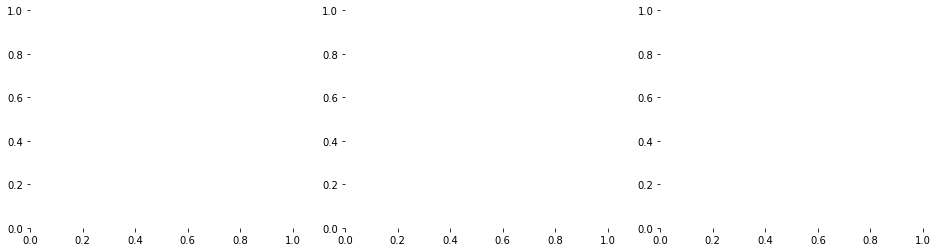

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
spines_off(axes)
ax1, ax2, ax3 = axes
vlines = [per.update_target_every * i for i in range(1, per.num_episodes//per.update_target_every + 1)]

ax1.set_title('Episode rewards')
ax1.plot(np.array(per.episode_rewards))


ax2.set_title('Estimated Q values')
ax2.plot(per.target_net_q_values)
ax2.hlines(100, 0, len(per.target_net_q_values), linestyles='dotted', linewidth=0.75)
ax2.vlines(vlines, 0, max(per.target_net_q_values), linestyles='dotted', linewidth=0.5, alpha=0.5);

ax3.set_title('Temporal difference errors')
ax3.plot(np.array(per.td_errors))



# TODOs: 

- OpenAI baseline comparison
- error and reward clipping!
- test the vectorized implementation vs non-vectorized
- check # of dead neurons
- Look at what gets a high TD error/priority in PER. Can simply sample minibatches from the PriorityMemory to see what comes up. Use state2image to visualize. 

altho Distributional paper says:

"In this work we used distributions with support bounded in [VMIN,VMAX]. Treating this support as a hyperparameter allows us to change the optimization problem by treating all extremal returns (e.g. greater than VMAX ) as equivalent. Surprisingly, a similar value clipping in DQN significantly degrades per- formance in most games. To take another example: in- terpreting the discount factor γ as a proper probability, as some authors have argued, leads to a different algorithm." ???

It's time to begin presenting my work
## Outline
- What have I done?
    - (Vectorized) DQN
    - DDQN
    - PER (leave for future update)
    - Distributional DQN (part 2)
- Why did I do it?
    - Amodi/80k, Sutton, Silver, DeepMind, AI Safety
- Key insights
    - Replay buffer
    - Target network
    - Reward clipping/error clipping
    - 
- Background material
    - Prereqs
    - Papers, videos, other tutorials, minimal theory, massimo, jaromiru.com

- Verification steps/tests
- Questions
    - How does Dist DQN interact with mostly deterministic envs?
    - Ways to verify/understand what's going on (amidfish)
    - Best workflows for developing/prototyping?
    - Challenges: time, memory, GPU, slow, data, statistical nature of results.
- Proof read
    - rename vars
    - refactor as needed
    - grammer/spelling
    - content

- Then: figure out styling.
